# Metagenome Environment Classification

#### By Sophie Yeh, Ed Kirton, Delaney Scheiern, and Haibi Lu

Little intro about metagenomes

## Setup

We have a file `db_setup.py` that creates a sqlite database containing tables for our official train/test split observations and labels. 

In [1]:
# General Imports
from helpers import (get_training_observations, 
                     get_training_labels)

import pandas as pd
import numpy as np
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import optuna

# Visualization/Processing
#%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import heatmap, plot_decision_regions
from sklearn.decomposition import TruncatedSVD
from mpl_toolkits.mplot3d import Axes3D

# Decision Tree
from sklearn.tree import DecisionTreeClassifier as dtc

# XGBoost
import xgboost as xgb

# Neural Network
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import metrics
tf.get_logger().setLevel('INFO')

# Model Evaluation
from model_evaluation.model_comparison import eval_wrapper
from helpers import (get_test_observations,
                     get_test_labels)

# Model Explainability
import shap

In [2]:
# Get training data
x_train = get_training_observations(main_bool=True)
y_train = get_training_labels(main_bool=True)

Getting all training observations from 'metagenome_classification.db'...
Getting all training labels from 'metagenome_classification.db'...


## Data Evaluation

In [3]:
x_train.isna().sum()

index
PF00001.19    0
PF00002.22    0
PF00003.20    0
PF00004.27    0
PF00005.25    0
             ..
PF17221.1     0
PF17222.1     0
PF17223.1     0
PF17224.1     0
PF17225.1     0
Length: 16306, dtype: int64

In [4]:
x_train.shape

(1249, 16306)

In [5]:
y_train.head(5)

index,EMPO_1,EMPO_2,EMPO_3
0,Host-associated,Plant,Plant rhizosphere
1,Free-living,Non-saline,Soil (non-saline)
2,Free-living,Saline,Water (saline)
3,Free-living,Non-saline,Water (non-saline)
4,Free-living,Non-saline,Soil (non-saline)


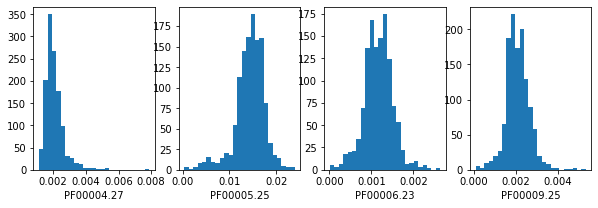

In [6]:
columns = [ 'PF00004.27','PF00005.25', 'PF00006.23','PF00009.25']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,3))
for idx, ax in enumerate(axes.flatten()):
    # plot histogram
    ax.hist(x_train[columns[idx]], bins = 25)
    # set xlabel
    ax.set_xlabel(columns[idx])

In [7]:
y_train_unique = y_train.groupby(['EMPO_1', 'EMPO_2','EMPO_3']).agg(Total = ('EMPO_3', 'count'))
df1 = y_train.groupby(['EMPO_1']).agg(Total = ('EMPO_1', 'count'))
df2 = y_train.groupby(['EMPO_1', 'EMPO_2']).agg(Total = ('EMPO_2', 'count'))
y_train_unique

Total
EMPO_1          EMPO_2     EMPO_3                        
Free-living     Non-saline Aerosol (non-saline)         8
                           Sediment (non-saline)       67
                           Soil (non-saline)          298
                           Subsurface (non-saline)    155
                           Surface (non-saline)         6
                           Water (non-saline)         244
                Saline     Hypersaline (saline)        16
                           Sediment (saline)           12
                           Surface (saline)             9
                           Water (saline)             288
Host-associated Animal     Animal corpus                3
                           Animal proximal gut         40
                Plant      Plant corpus                 2
                           Plant rhizosphere           97
                           Plant surface                4

In [8]:
x_train_col_sum = x_train.sum(axis=0)
print(x_train_col_sum.values)
count = np.count_nonzero(x_train_col_sum.values)
print('Count nonzero:', count)
x_train_col_sum.sort_values(ascending=False).head(10)

[3.89723507e-01 1.13797650e-02 1.13860621e-02 ... 7.65861508e-05
 5.53812658e-05 3.40367403e-04]
Count nonzero: 16306


index
PF00005.25    17.982042
PF00072.22    10.456070
PF02518.24     7.008188
PF00528.20     6.330046
PF00501.26     6.231773
PF00873.17     5.893384
PF07690.14     5.750278
PF00106.23     5.413189
PF00171.20     4.327960
PF13561.4      4.324083
dtype: float64

(array([   2.,    7.,   13.,   65.,  292.,  867.,  995.,  784.,  738.,
         760.,  859., 1001., 1077., 1046.,  907.,  807.,  774.,  842.,
         828.,  786.,  705.,  609.,  649.,  469.,  240.,  110.,   52.,
          16.,    4.,    2.]),
 array([-13.90701318, -13.34713362, -12.78725406, -12.2273745 ,
        -11.66749494, -11.10761538, -10.54773583,  -9.98785627,
         -9.42797671,  -8.86809715,  -8.30821759,  -7.74833803,
         -7.18845847,  -6.62857892,  -6.06869936,  -5.5088198 ,
         -4.94894024,  -4.38906068,  -3.82918112,  -3.26930156,
         -2.70942201,  -2.14954245,  -1.58966289,  -1.02978333,
         -0.46990377,   0.08997579,   0.64985535,   1.2097349 ,
          1.76961446,   2.32949402,   2.88937358]),
 <BarContainer object of 30 artists>)

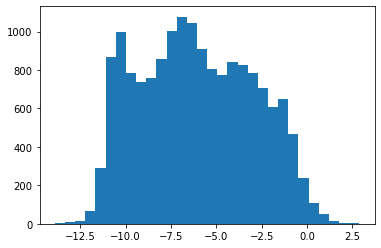

In [9]:
plt.hist(np.log(x_train_col_sum), bins=30)

In [10]:
column_count = []
for column_name in x_train.columns:
    column = x_train[column_name]
    # Get the count of non-Zeros values in column
    count_of_non_zeros = (column != 0).sum()
    column_count.append(count_of_non_zeros)


(array([4406., 1140.,  738.,  483.,  404.,  386.,  331.,  355.,  327.,
         304.,  247.,  182.,  179.,  161.,  136.,  130.,  110.,  105.,
         146.,  122.,  114.,  119.,  126.,  132.,  113.,  114.,  124.,
         109.,  112.,  123.,  112.,  124.,  132.,  116.,  123.,  140.,
         110.,  137.,  125.,  149.,  156.,  147.,  170.,  159.,  181.,
         196.,  231.,  281.,  351., 1588.]),
 array([1.00000e+00, 2.59600e+01, 5.09200e+01, 7.58800e+01, 1.00840e+02,
        1.25800e+02, 1.50760e+02, 1.75720e+02, 2.00680e+02, 2.25640e+02,
        2.50600e+02, 2.75560e+02, 3.00520e+02, 3.25480e+02, 3.50440e+02,
        3.75400e+02, 4.00360e+02, 4.25320e+02, 4.50280e+02, 4.75240e+02,
        5.00200e+02, 5.25160e+02, 5.50120e+02, 5.75080e+02, 6.00040e+02,
        6.25000e+02, 6.49960e+02, 6.74920e+02, 6.99880e+02, 7.24840e+02,
        7.49800e+02, 7.74760e+02, 7.99720e+02, 8.24680e+02, 8.49640e+02,
        8.74600e+02, 8.99560e+02, 9.24520e+02, 9.49480e+02, 9.74440e+02,
        9.99400e

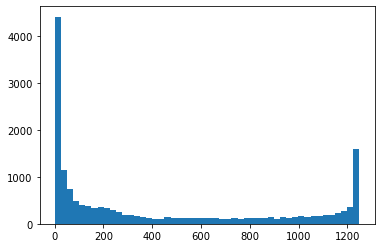

In [11]:
plt.hist((column_count), bins=50)

In [12]:
train_full = x_train.join(y_train)

In [13]:
train_vis = train_full.loc[:,['PF00005.25','PF00072.22','PF02518.24','PF00528.20','PF00501.26','PF00873.17','PF07690.14','PF00106.23','PF00171.20','PF13561.4','EMPO_3']]
train_vis

index,PF00005.25,PF00072.22,PF02518.24,PF00528.20,PF00501.26,PF00873.17,PF07690.14,PF00106.23,PF00171.20,PF13561.4,EMPO_3
0,0.021986,0.010637,0.006406,0.008616,0.009025,0.006361,0.006286,0.009038,0.005429,0.005995,Plant rhizosphere
1,0.015320,0.014472,0.008454,0.004230,0.005455,0.009461,0.004661,0.005838,0.004254,0.003640,Soil (non-saline)
2,0.011640,0.010137,0.007351,0.002869,0.003822,0.007167,0.004060,0.004656,0.003859,0.003739,Water (saline)
3,0.018117,0.003943,0.003509,0.005066,0.005204,0.005372,0.005106,0.004465,0.004110,0.003401,Water (non-saline)
4,0.014518,0.013535,0.007244,0.004532,0.006034,0.010300,0.006015,0.006700,0.004520,0.004845,Soil (non-saline)
...,...,...,...,...,...,...,...,...,...,...,...
1244,0.014123,0.010215,0.006161,0.003923,0.005975,0.005810,0.005587,0.005181,0.003035,0.004298,Soil (non-saline)
1245,0.011873,0.012079,0.008721,0.002453,0.006166,0.008962,0.003919,0.002349,0.001708,0.001467,Sediment (non-saline)
1246,0.014302,0.004889,0.004336,0.004915,0.003911,0.003061,0.003435,0.003350,0.003962,0.002321,Water (non-saline)
1247,0.012999,0.008439,0.006208,0.003344,0.003962,0.006096,0.003879,0.003086,0.002781,0.002148,Water (non-saline)


In [14]:
empo_3 = pd.get_dummies(train_vis.EMPO_3, prefix='EMPO_3')
train_vis = train_full.loc[:,['PF00005.25','PF00072.22','PF02518.24','PF00528.20','PF00501.26','PF00873.17','PF07690.14','PF00106.23','PF00171.20','PF13561.4']].join(empo_3)

In [15]:
train_vis

,PF00005.25,PF00072.22,PF02518.24,PF00528.20,PF00501.26,PF00873.17,PF07690.14,PF00106.23,PF00171.20,PF13561.4,...,EMPO_3_Plant rhizosphere,EMPO_3_Plant surface,EMPO_3_Sediment (non-saline),EMPO_3_Sediment (saline),EMPO_3_Soil (non-saline),EMPO_3_Subsurface (non-saline),EMPO_3_Surface (non-saline),EMPO_3_Surface (saline),EMPO_3_Water (non-saline),EMPO_3_Water (saline)
0,0.021986,0.010637,0.006406,0.008616,0.009025,0.006361,0.006286,0.009038,0.005429,0.005995,...,1,0,0,0,0,0,0,0,0,0
1,0.015320,0.014472,0.008454,0.004230,0.005455,0.009461,0.004661,0.005838,0.004254,0.003640,...,0,0,0,0,1,0,0,0,0,0
2,0.011640,0.010137,0.007351,0.002869,0.003822,0.007167,0.004060,0.004656,0.003859,0.003739,...,0,0,0,0,0,0,0,0,0,1
3,0.018117,0.003943,0.003509,0.005066,0.005204,0.005372,0.005106,0.004465,0.004110,0.003401,...,0,0,0,0,0,0,0,0,1,0
4,0.014518,0.013535,0.007244,0.004532,0.006034,0.010300,0.006015,0.006700,0.004520,0.004845,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,0.014123,0.010215,0.006161,0.003923,0.005975,0.005810,0.005587,0.005181,0.003035,0.004298,...,0,0,0,0,1,0,0,0,0,0
1245,0.011873,0.012079,0.008721,0.002453,0.006166,0.008962,0.003919,0.002349,0.001708,0.001467,...,0,0,1,0,0,0,0,0,0,0
1246,0.014302,0.004889,0.004336,0.004915,0.003911,0.003061,0.003435,0.003350,0.003962,0.002321,...,0,0,0,0,0,0,0,0,1,0
1247,0.012999,0.008439,0.006208,0.003344,0.003962,0.006096,0.003879,0.003086,0.002781,0.002148,...,0,0,0,0,0,0,0,0,1,0


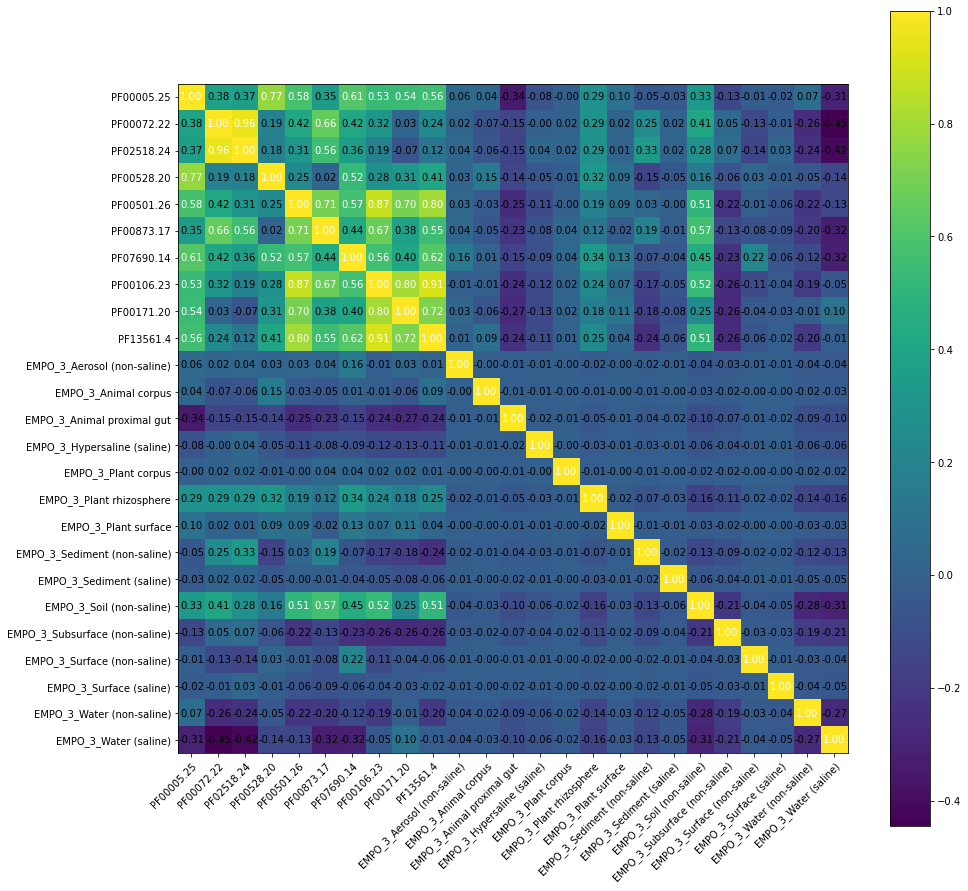

In [16]:
cm = train_vis.corr().values
hm = heatmap(
    cm,
    row_names=train_vis.columns,
    column_names=train_vis.columns,
    figsize=(15, 15)
)


From now on, we will only be looking at EMPO 3.

##### Dimensionality Reduction and 3D Visualization

Since it is difficult to gain meaning from over 16k features/dimensions, we will use dimensionality reduction in an effort to visualize how effective our classification may be. If we are able to see clusters form at the lower dimension, then our data will likely react well to our classification algorithms.

In [17]:
svd = TruncatedSVD(n_components=3, n_iter=7, random_state=27)
svd.fit(x_train)

svd_x_train = svd.transform(x_train)
df_3d = pd.DataFrame(svd_x_train)

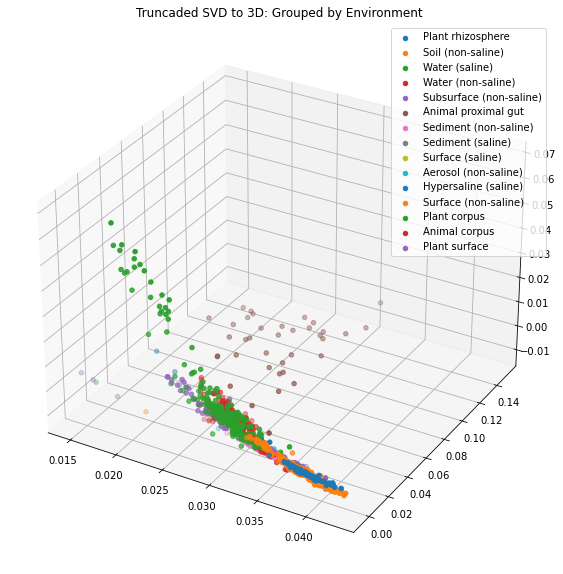

In [18]:
#%matplotlib notebook
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

for lab in y_train['EMPO_3'].unique():
    x = df_3d.loc[list(y_train['EMPO_3'] == lab), 0]
    y = df_3d.loc[list(y_train['EMPO_3'] == lab), 1]
    z = df_3d.loc[list(y_train['EMPO_3'] == lab), 2]
    ax.scatter(list(x), list(y), list(z), label=lab)
    
ax.set_title("Truncaded SVD to 3D: Grouped by Environment")
ax.legend(loc="best")

plt.show()

We can see that our environments are grouped together in almost linear groupings, and `Animal proximal gut` almost has an entire dimension to itself.

## Model Creation

Controls for preventing accidental retraining:

In [19]:
retraining_decision_tree = True
retraining_xgb = True
retraining_nn = True

For XGBoost and FFNN, we need to encode our categories into integers. We will fit a LabelEncoder for this.

In [20]:
le = LabelEncoder()
le.fit(y_train['EMPO_3'])
# Save encoder
dump(le,'model_joblibs/final_labelEncoder.joblib')

['model_joblibs/final_labelEncoder.joblib']

### Decision Tree

In [21]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0, stratify=y_train['EMPO_3'])


In [22]:
# Create and fit many decision tree classifier options
model_3 = dtc(criterion = 'entropy', max_depth = 3)
model_3.fit(x_tr, y_tr['EMPO_3'])

model_5 = dtc(criterion = 'entropy', max_depth = 5)
model_5.fit(x_tr, y_tr['EMPO_3'])

model_10 = dtc(criterion = 'entropy', max_depth = 10)
model_10.fit(x_tr, y_tr['EMPO_3'])

model_20 = dtc(criterion = 'entropy', max_depth = 20)
model_20.fit(x_tr, y_tr['EMPO_3'])

model_50 = dtc(criterion = 'entropy', max_depth = 50)
model_50.fit(x_tr, y_tr['EMPO_3'])

model_70 = dtc(criterion = 'entropy', max_depth = 70)
model_70.fit(x_tr, y_tr['EMPO_3'])

DecisionTreeClassifier(criterion='entropy', max_depth=70)

In [23]:
# Check metric of interest
pred_model_3 = model_3.predict(x_val)
acc = f1_score(y_val['EMPO_3'], pred_model_3, average='weighted')
print(f"Weighted F1 Score of model_3 is {acc}")

pred_model_5 = model_5.predict(x_val)
acc = f1_score(y_val['EMPO_3'], pred_model_5, average='weighted')
print(f"Weighted F1 Score of model_5 is {acc}")

pred_model_10 = model_10.predict(x_val)
acc = f1_score(y_val['EMPO_3'], pred_model_10, average='weighted')
print(f"Weighted F1 Score of model_10 is {acc}")

pred_model_20 = model_20.predict(x_val)
acc = f1_score(y_val['EMPO_3'], pred_model_20, average='weighted')
print(f"Weighted F1 Score of model_20 is {acc}")

pred_model_50 = model_50.predict(x_val)
acc = f1_score(y_val['EMPO_3'], pred_model_50, average='weighted')
print(f"Weighted F1 Score of model_50 is {acc}")

pred_model_70 = model_70.predict(x_val)
acc = f1_score(y_val['EMPO_3'], pred_model_70, average='weighted')
print(f"Weighted F1 Score of model_70 is {acc}")

Weighted F1 Score of model_3 is 0.6858460884295076
Weighted F1 Score of model_5 is 0.8101033548610753
Weighted F1 Score of model_10 is 0.8266003502693287
Weighted F1 Score of model_20 is 0.8121302592955678
Weighted F1 Score of model_50 is 0.8230912428857372
Weighted F1 Score of model_70 is 0.8270428883643673


In most trials, the best Decision Tree, according to weighted F1 score, is the tree with a max depth of 20. Next, we will fit a model of this depth on the entire training set and save the final model.

In [24]:
dtc_final = dtc(criterion = 'entropy', max_depth = 20)
if retraining_decision_tree:
    dtc_final.fit(x_train, y_train['EMPO_3'])

In [25]:
if retraining_decision_tree:
    dump(dtc_final, 'model_joblibs/final_decision_tree.joblib')

### XGBoost Model

In [26]:
le = load('model_joblibs/final_labelEncoder.joblib')
    
y_train_transformed = le.transform(y_train['EMPO_3'])

x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train_transformed, test_size=0.2, random_state=0, stratify=y_train_transformed)   


Will will use Optuna to help hyperparameter tuning for XGBoost.

In [27]:
def objective_xgb(trial, x_tr=x_tr, x_val=x_val, y_tr=y_tr, y_val=y_val):
    
    # Set up XGBoost hyperparameter space
    params = {
        #'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        #'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.7, 0.8, 0.9, 1.0]),
        #'subsample': trial.suggest_categorical('subsample', [1.0]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1),
        'n_estimators': 200,
        'max_depth': trial.suggest_int('max_depth', 3,10),
        #'random_state': trial.suggest_categorical('random_state', [2022]),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 20)
    }
    
    # Create XGBoost model
    clf = xgb.XGBClassifier(**params,
                            objective='multi:softmax',
                            num_class=15,
                            eval_metric='mlogloss',
                            use_label_encoder=False)
    
    # Fit XGBoost model
    clf.fit(x_tr, y_tr,
            eval_set=[(x_tr, y_tr), (x_val, y_val)],
            verbose=False)
    
    pred = clf.predict(x_val)
    accuracy = accuracy_score(y_val, pred)
    f1 = f1_score(y_val, pred, average='weighted')
    print('Accuracy Score:', accuracy)
    print('F1 Score:', f1)
    
    return f1
    

In [28]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=2)

print('Number of finished trials:', len(study_xgb.trials))
print('Best trial:', study_xgb.best_trial.params)

[I 2022-08-03 18:28:13,612] A new study created in memory with name: no-name-a3451772-79e5-4efc-9f35-a3dac7f22f5d
[I 2022-08-03 18:30:32,613] Trial 0 finished with value: 0.900490407310465 and parameters: {'reg_alpha': 2.811715257231915, 'colsample_bytree': 1.0, 'learning_rate': 0.028645760791784134, 'max_depth': 4, 'min_child_weight': 3}. Best is trial 0 with value: 0.900490407310465.


Accuracy Score: 0.904
F1 Score: 0.900490407310465


[I 2022-08-03 18:31:12,797] Trial 1 finished with value: 0.806022783847748 and parameters: {'reg_alpha': 9.262629761784526, 'colsample_bytree': 0.8, 'learning_rate': 0.9023543707693343, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 0 with value: 0.900490407310465.


Accuracy Score: 0.828
F1 Score: 0.806022783847748
Number of finished trials: 2
Best trial: {'reg_alpha': 2.811715257231915, 'colsample_bytree': 1.0, 'learning_rate': 0.028645760791784134, 'max_depth': 4, 'min_child_weight': 3}


In [29]:
# Custom metric for F1
def f1_eval(y_pred, dtrain):
    err = 1-f1_score(np.round(dtrain), np.round(y_pred), average='weighted')
    return err

Here, we only demonstrated two trials of Optuna training our XGBoost model. The full training process can be seen in `modeling/final_xgboost.ipynb`. Below, we manually set the parameters from the best trial in that training process.

In [30]:
# Parameters for best and final model

#best_xgb_params = study_xgb.best_trial.params
best_xgb_params = {'reg_lambda': 0.01505853587641787, 'reg_alpha': 0.03476744563778924, 
                   'colsample_bytree': 0.7, 'learning_rate': 0.14665385125779304, 
                   'max_depth': 6, 'min_child_weight': 2}

best_xgb = xgb.XGBClassifier(**best_xgb_params,
                             objective='multi:softmax',
                             num_class=15,
                             n_estimators=90,
                             eval_metric=f1_eval,
                             use_label_encoder=False)

In [31]:
 
def plot_xgb_curves(model):
    hist = model.evals_result()
    x_arr = np.arange(len(hist['validation_0']['mlogloss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['validation_0']['mlogloss'], label='Train loss')
    if 'validation_1' in hist:
        ax.plot(x_arr, hist['validation_1']['mlogloss'], label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, np.ones(shape=len(hist['validation_0']['f1_eval']))-hist['validation_0']['f1_eval'], label='Train F1')
    if 'validation_1' in hist:
        ax.plot(x_arr, np.ones(shape=len(hist['validation_1']['f1_eval']))-hist['validation_1']['f1_eval'], label='Validation F1')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('F1 Score', size=15)
    ax.set_ylim(0,1)
    plt.show()
    
    
def fit_model(model, x_tr=x_tr, y_tr=y_tr, eval_set=[(x_tr, y_tr), (x_val, y_val)], x_true=x_val, y_true=y_val):
    model.fit(x_tr,y_tr,
              eval_set=eval_set,
              verbose=0)
    # predict validation data
    y_pred = model.predict(x_true)
    # print f1 score 
    print('Training Set F1 Score:', f1_score(y_true, y_pred, average='weighted'))
    return y_pred

In [32]:
# Plot training and validation set curves
best_pred_xgb = fit_model(best_xgb)

Training Set F1 Score: 0.9133302450888128


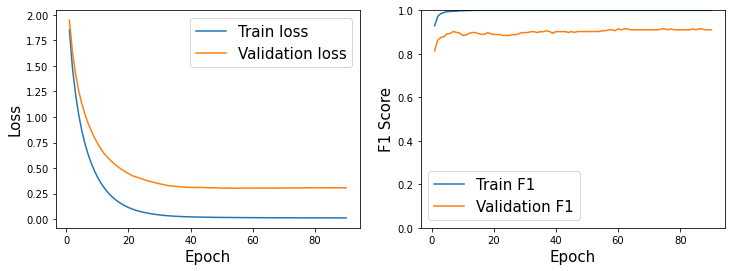

In [33]:
plot_xgb_curves(best_xgb)

In [34]:
# Retrain best model on whole training set
if retraining_xgb:
    best_xgb.fit(x_train, y_train_transformed,
             eval_set=[(x_train, y_train_transformed)],
             verbose=0)

In [35]:
# Save best model as joblib or pkl file to 'model_joblibs' folder
if retraining_xgb:
    dump(best_xgb, 'model_joblibs/final_xgb_model.joblib')

### Neural Network

We will use the same validation split and label encoding as the XGBoost model. We will also use Optuna to choose our hyperparameters.

In [36]:
K = tf.keras.backend

def build_model(
    activation='relu',
    hidden_layer_sizes=[],
    final_layer_activation='softmax',
    dropout=0.0,
    optimizer='Adam',
    learning_rate=0.01,
    kernel_regularizer=1e-5,
    bias_regularizer=1e-5,
    activity_regularizer=1e-5,
    n_classes=15
):
    """Build a multi-class logistic regression model using Keras.

    Args:
      n_classes: Number of output classes in the dataset.
      hidden_layer_sizes: A list with the number of units in each hidden layer.
      activation: The activation function to use for the hidden layers.
      optimizer: The optimizer to use (SGD, Adam).
      learning_rate: The desired learning rate for the optimizer.

    Returns:
      model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    
    for hidden_layer_size in hidden_layer_sizes:
        if hidden_layer_size > n_classes:
            model.add(tf.keras.layers.Dense(
                hidden_layer_size,
                activation=activation,
                kernel_regularizer=tf.keras.regularizers.L2(kernel_regularizer),
                bias_regularizer=tf.keras.regularizers.L2(bias_regularizer),
                activity_regularizer=tf.keras.regularizers.L2(activity_regularizer)
            ))
            if dropout > 0:
                model.add(tf.keras.layers.Dropout(dropout))

    model.add(tf.keras.layers.Dense(
        n_classes,
        activation=final_layer_activation,
        kernel_regularizer=tf.keras.regularizers.L2(kernel_regularizer),
        bias_regularizer=tf.keras.regularizers.L2(bias_regularizer),
        activity_regularizer=tf.keras.regularizers.L2(activity_regularizer)
    ))
    opt = None
    if optimizer == "SGD":
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise f"Unsupported optimizer, {optimizer}"
    model.compile(
        loss="categorical_crossentropy", optimizer=opt, 
        metrics=[tfa.metrics.F1Score(num_classes=15, average='weighted')]
    )
    return model
    

In [37]:
def objective_1_layer(trial, x_tr=x_tr, x_val=x_val, y_tr=y_tr, y_val=y_val):
    
    # Set up XGBoost hyperparameter space
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.01),
        'hidden_layer_size1': trial.suggest_int('hidden_layer_size1', 0, 1024),
        'kernel_regularizer': trial.suggest_float('kernel_regularizer', 1e-10, 1e-4),
        'bias_regularizer': trial.suggest_float('bias_regularizer', 1e-10, 1e-4),
        'activity_regularizer': trial.suggest_float('activity_regularizer', 1e-10, 1e-4),
        'dropout': trial.suggest_float('dropout', 0, 0.1)
    }
    
    hidden_layer_sizes = [params.pop('hidden_layer_size1')]
    
    y_tr_one_hot = K.one_hot(K.cast(y_tr, dtype='int64'), 15)
    y_val_one_hot = K.one_hot(K.cast(y_val, dtype='int64'), 15)
    
    # Create model
    nn = build_model(
        **params,
        n_classes=15,
        optimizer='Adam',
        final_layer_activation='softmax',
        hidden_layer_sizes=hidden_layer_sizes
    )
    
    # Fit model
    nn.fit(x=x_tr,
           y=y_tr_one_hot,
           epochs=50,
           batch_size=64,
           verbose=0)
    
    evaluation = nn.evaluate(x=x_val, y=y_val_one_hot, verbose=0, return_dict=True)
    f1_score = evaluation['f1_score']
    loss = evaluation['loss']
    
    print(f'F1 Score: {f1_score}; Loss={loss}')
    
    return f1_score
    

In [38]:
def objective_2_layer(trial, x_tr=x_tr, x_val=x_val, y_tr=y_tr, y_val=y_val):
    
    # Set up XGBoost hyperparameter space
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.01),
        'hidden_layer_size1': trial.suggest_int('hidden_layer_size1', 0, 1024),
        'hidden_layer_size2': trial.suggest_int('hidden_layer_size2', 0, 1024),
        'kernel_regularizer': trial.suggest_float('kernel_regularizer', 1e-10, 1e-4),
        'bias_regularizer': trial.suggest_float('bias_regularizer', 1e-10, 1e-4),
        'activity_regularizer': trial.suggest_float('activity_regularizer', 1e-10, 1e-4),
        'dropout': trial.suggest_float('dropout', 0, 0.1)
    }
    
    hidden_layer_sizes = [params.pop('hidden_layer_size1'), params.pop('hidden_layer_size2')]
    
    y_tr_one_hot = K.one_hot(K.cast(y_tr, dtype='int64'), 15)
    y_val_one_hot = K.one_hot(K.cast(y_val, dtype='int64'), 15)
    
    # Create model
    nn = build_model(
        **params,
        n_classes=15,
        optimizer='Adam',
        final_layer_activation='softmax',
        hidden_layer_sizes=hidden_layer_sizes
    )
    
    # Fit model
    nn.fit(x=x_tr,
           y=y_tr_one_hot,
           epochs=50,
           batch_size=64,
           verbose=0)
    
    evaluation = nn.evaluate(x=x_val, y=y_val_one_hot, verbose=0, return_dict=True)
    f1_score = evaluation['f1_score']
    loss = evaluation['loss']
    
    print(f'F1 Score: {f1_score}; Loss={loss}')
    
    return f1_score
    

In [39]:
def objective_3_layer(trial, x_tr=x_tr, x_val=x_val, y_tr=y_tr, y_val=y_val):
    
    # Set up XGBoost hyperparameter space
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.01),
        'hidden_layer_size1': trial.suggest_int('hidden_layer_size1', 0, 1024),
        'hidden_layer_size2': trial.suggest_int('hidden_layer_size2', 0, 1024),
        'hidden_layer_size3': trial.suggest_int('hidden_layer_size3', 0, 1024),
        'kernel_regularizer': trial.suggest_float('kernel_regularizer', 1e-10, 1e-4),
        'bias_regularizer': trial.suggest_float('bias_regularizer', 1e-10, 1e-4),
        'activity_regularizer': trial.suggest_float('activity_regularizer', 1e-10, 1e-4),
        'dropout': trial.suggest_float('dropout', 0, 0.1)
    }
    
    hidden_layer_sizes = [params.pop('hidden_layer_size1'), params.pop('hidden_layer_size2'), params.pop('hidden_layer_size3')]
    
    y_tr_one_hot = K.one_hot(K.cast(y_tr, dtype='int64'), 15)
    y_val_one_hot = K.one_hot(K.cast(y_val, dtype='int64'), 15)
    
    # Create model
    nn = build_model(
        **params,
        n_classes=15,
        optimizer='Adam',
        final_layer_activation='softmax',
        hidden_layer_sizes=hidden_layer_sizes
    )
    
    # Fit model
    nn.fit(x=x_tr,
           y=y_tr_one_hot,
           epochs=50,
           batch_size=64,
           verbose=0)
    
    evaluation = nn.evaluate(x=x_val, y=y_val_one_hot, verbose=0, return_dict=True)
    f1_score = evaluation['f1_score']
    loss = evaluation['loss']
    
    print(f'F1 Score: {f1_score}; Loss={loss}')
    
    return f1_score
    

In [40]:
study_nn_1 = optuna.create_study(direction='maximize')
study_nn_1.optimize(objective_1_layer, n_trials=2)

print('Number of finished trials:', len(study_nn_1.trials))
print('Best trial:', study_nn_1.best_trial.params)

[I 2022-08-03 18:32:29,505] A new study created in memory with name: no-name-9a1d7e5b-51c4-4e69-aeaa-5ab9015c68f9
2022-08-03 18:32:29.508312: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-03 18:32:29.508484: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


2022-08-03 18:32:29.770180: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-03 18:32:30.220350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-03 18:32:40.940805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
[I 2022-08-03 18:32:41,108] Trial 0 finished with value: 0.3885181248188019 and parameters: {'learning_rate': 0.0007366661303610312, 'hidden_layer_size1': 479, 'kernel_regularizer': 9.126627365412704e-05, 'bias_regularizer': 5.399257802052485e-05, 'activity_regularizer': 2.957604876673205e-06, 'dropout': 0.023619006711260437}. Best is trial 0 with value: 0.3885181248188019.


F1 Score: 0.3885181248188019; Loss=1.5496795177459717


2022-08-03 18:32:41.526614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-03 18:32:54.379950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
[I 2022-08-03 18:32:54,555] Trial 1 finished with value: 0.5914683938026428 and parameters: {'learning_rate': 0.0011330452635302426, 'hidden_layer_size1': 946, 'kernel_regularizer': 7.197582809402162e-05, 'bias_regularizer': 3.846978861452947e-05, 'activity_regularizer': 4.187871881087039e-05, 'dropout': 0.00010180700972083346}. Best is trial 1 with value: 0.5914683938026428.


F1 Score: 0.5914683938026428; Loss=1.3439558744430542
Number of finished trials: 2
Best trial: {'learning_rate': 0.0011330452635302426, 'hidden_layer_size1': 946, 'kernel_regularizer': 7.197582809402162e-05, 'bias_regularizer': 3.846978861452947e-05, 'activity_regularizer': 4.187871881087039e-05, 'dropout': 0.00010180700972083346}


In [41]:
study_nn_2 = optuna.create_study(direction='maximize')
study_nn_2.optimize(objective_2_layer, n_trials=2)

print('Number of finished trials:', len(study_nn_2.trials))
print('Best trial:', study_nn_2.best_trial.params)

[I 2022-08-03 18:32:54,559] A new study created in memory with name: no-name-16e8787e-ad20-454b-aee2-1239dc8e05a8
2022-08-03 18:32:54.995764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-03 18:33:04.067285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
[I 2022-08-03 18:33:04,246] Trial 0 finished with value: 0.7260204553604126 and parameters: {'learning_rate': 0.001602853496369497, 'hidden_layer_size1': 39, 'hidden_layer_size2': 88, 'kernel_regularizer': 3.052182669526307e-05, 'bias_regularizer': 2.4961606520808146e-05, 'activity_regularizer': 9.776168912129823e-05, 'dropout': 0.04731045270695947}. Best is trial 0 with value: 0.7260204553604126.


F1 Score: 0.7260204553604126; Loss=0.9253453016281128


2022-08-03 18:33:04.739639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-03 18:33:20.356793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
[I 2022-08-03 18:33:20,556] Trial 1 finished with value: 0.793874979019165 and parameters: {'learning_rate': 0.006748606355938171, 'hidden_layer_size1': 1000, 'hidden_layer_size2': 571, 'kernel_regularizer': 8.938586777339447e-05, 'bias_regularizer': 3.283552299187616e-05, 'activity_regularizer': 4.7353485386507536e-05, 'dropout': 0.07340461390963175}. Best is trial 1 with value: 0.793874979019165.


F1 Score: 0.793874979019165; Loss=0.920563817024231
Number of finished trials: 2
Best trial: {'learning_rate': 0.006748606355938171, 'hidden_layer_size1': 1000, 'hidden_layer_size2': 571, 'kernel_regularizer': 8.938586777339447e-05, 'bias_regularizer': 3.283552299187616e-05, 'activity_regularizer': 4.7353485386507536e-05, 'dropout': 0.07340461390963175}


In [42]:
study_nn_3 = optuna.create_study(direction='maximize')
study_nn_3.optimize(objective_3_layer, n_trials=2)

print('Number of finished trials:', len(study_nn_3.trials))
print('Best trial:', study_nn_3.best_trial.params)

[I 2022-08-03 18:33:20,561] A new study created in memory with name: no-name-93fc306f-3ce8-447b-be31-ceb007e8379f
2022-08-03 18:33:21.316311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-03 18:33:32.986619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
[I 2022-08-03 18:33:33,226] Trial 0 finished with value: 0.5598258972167969 and parameters: {'learning_rate': 0.00011533273686365622, 'hidden_layer_size1': 390, 'hidden_layer_size2': 246, 'hidden_layer_size3': 295, 'kernel_regularizer': 8.523837108227667e-05, 'bias_regularizer': 3.139731465552413e-05, 'activity_regularizer': 3.276566127485537e-05, 'dropout': 0.04014903470942896}. Best is trial 0 with value: 0.5598258972167969.


F1 Score: 0.5598258972167969; Loss=1.1699031591415405


2022-08-03 18:33:33.808615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-03 18:33:48.739501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
[I 2022-08-03 18:33:48,976] Trial 1 finished with value: 0.8679512739181519 and parameters: {'learning_rate': 0.0007855705868530646, 'hidden_layer_size1': 956, 'hidden_layer_size2': 798, 'hidden_layer_size3': 939, 'kernel_regularizer': 6.732727336010532e-05, 'bias_regularizer': 3.025470994571147e-05, 'activity_regularizer': 8.441590071499332e-05, 'dropout': 0.034262703793814034}. Best is trial 1 with value: 0.8679512739181519.


F1 Score: 0.8679512739181519; Loss=0.6745593547821045
Number of finished trials: 2
Best trial: {'learning_rate': 0.0007855705868530646, 'hidden_layer_size1': 956, 'hidden_layer_size2': 798, 'hidden_layer_size3': 939, 'kernel_regularizer': 6.732727336010532e-05, 'bias_regularizer': 3.025470994571147e-05, 'activity_regularizer': 8.441590071499332e-05, 'dropout': 0.034262703793814034}


These three Optuna studies are demonstrations of our hyperparameter training for different Neural Networks with different numbers of layers. Full tuning was completed in `final_ffnn_1.ipynb`, `final_ffnn_2.ipynb`, and `final_ffnn_3.ipynb`. The best parameters are entered below, and we'll compare the Weighted F1 scores.

In [43]:
y_tr_one_hot = K.one_hot(K.cast(y_tr, dtype='int64'), 15)
y_val_one_hot = K.one_hot(K.cast(y_val, dtype='int64'), 15)

In [44]:
best_nn_1_params = {'learning_rate': 0.009590263929390183, 'hidden_layer_size1': 663, 
                    'kernel_regularizer': 3.224294748659483e-08, 'bias_regularizer': 9.494455246549682e-05, 
                    'activity_regularizer': 7.54622803748681e-05, 'dropout': 0.07189361802417232}

hidden_layer_sizes = [best_nn_1_params.pop('hidden_layer_size1')]

# Create model
nn1 = build_model(
    **best_nn_1_params,
    n_classes=15,
    optimizer='Adam',
    final_layer_activation='softmax',
    hidden_layer_sizes=hidden_layer_sizes
)

# Fit model
history_nn_1 = nn1.fit(x=x_tr,
       y=y_tr_one_hot,
       validation_data=(x_val, y_val_one_hot),
       epochs=100,
       batch_size=64,
       verbose=0)


2022-08-03 18:33:49.413254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-03 18:33:49.973321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [45]:
best_nn_2_params = {'learning_rate': 0.008898464308222692, 'hidden_layer_size1': 495, 
                    'hidden_layer_size2': 765, 'kernel_regularizer': 8.856221026715601e-07, 
                    'bias_regularizer': 7.737459161815707e-05, 
                    'activity_regularizer': 1.561737020593232e-05, 'dropout': 0.018195406988695262}

hidden_layer_sizes = [best_nn_2_params.pop('hidden_layer_size1'), 
                      best_nn_2_params.pop('hidden_layer_size2')]
    
# Create model
nn2 = build_model(
    **best_nn_2_params,
    n_classes=15,
    optimizer='Adam',
    final_layer_activation='softmax',
    hidden_layer_sizes=hidden_layer_sizes
)
    
# Fit model
history_nn_2 = nn2.fit(x=x_tr,
       y=y_tr_one_hot,
       validation_data=(x_val, y_val_one_hot),
       epochs=100,
       batch_size=64,
       verbose=0)


2022-08-03 18:34:16.278664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-03 18:34:16.982201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [46]:
best_nn_3_params = {'learning_rate': 0.00399057337146822, 'hidden_layer_size1': 321, 
                    'hidden_layer_size2': 571, 'hidden_layer_size3': 233, 
                    'kernel_regularizer': 2.412083737943694e-07, 'bias_regularizer': 3.7539762303542793e-05, 
                    'activity_regularizer': 4.493669155490493e-05, 'dropout': 0.0816250430781725}

hidden_layer_sizes = [best_nn_3_params.pop('hidden_layer_size1'), 
                      best_nn_3_params.pop('hidden_layer_size2'), 
                      best_nn_3_params.pop('hidden_layer_size3')]

# Create model
nn3 = build_model(
    **best_nn_3_params,
    n_classes=15,
    optimizer='Adam',
    final_layer_activation='softmax',
    hidden_layer_sizes=hidden_layer_sizes
)

# Fit model
history_nn_3 = nn3.fit(x=x_tr,
       y=y_tr_one_hot,
       validation_data=(x_val, y_val_one_hot),
       epochs=100,
       batch_size=64,
       verbose=0)


2022-08-03 18:34:44.742738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-03 18:34:45.619859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [47]:
def plot_nn_curves(hist):
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], label='Train loss')
    ax.plot(x_arr, hist['val_loss'], label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['f1_score'], label='Train F1 score')
    ax.plot(x_arr, hist['val_f1_score'], label='Validation F1 score')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Weighted F1 Score', size=15)
    ax.set_ylim(0,1)
    plt.show()

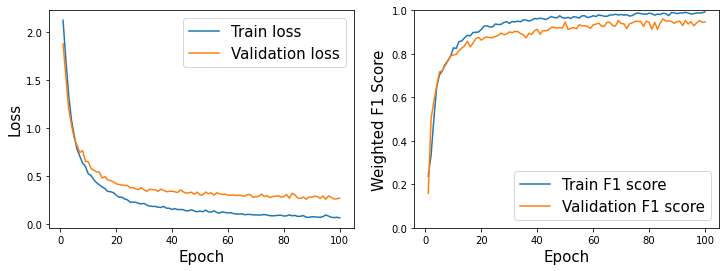

In [48]:
plot_nn_curves(history_nn_1.history)

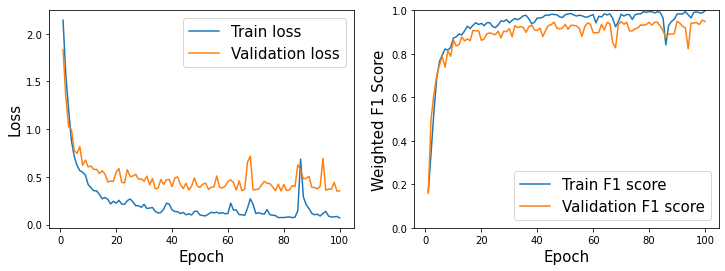

In [49]:
plot_nn_curves(history_nn_2.history)

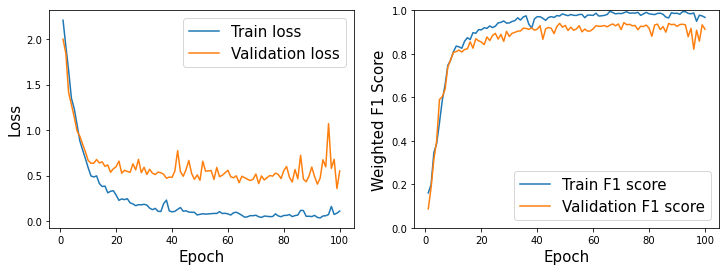

In [50]:
plot_nn_curves(history_nn_3.history)

In [51]:
print('Validation F1 Score of 1 Layer:', history_nn_1.history['val_f1_score'][-1])
print('Validation F1 Score of 2 Layer:', history_nn_2.history['val_f1_score'][-1])
print('Validation F1 Score of 3 Layer:', history_nn_3.history['val_f1_score'][-1])

Validation F1 Score of 1 Layer: 0.9466294050216675
Validation F1 Score of 2 Layer: 0.9490211009979248
Validation F1 Score of 3 Layer: 0.9133524894714355


We can see that the model with 2 layers performs best. The 1 layer underfits, while the 3 layer overfits.

In [52]:
# Retrain best NN on whole training set
if retraining_nn: 
    y_train_one_hot = K.one_hot(K.cast(y_train_transformed, dtype='int64'), 15)

    best_nn_2_params = {'learning_rate': 0.006729391788774663, 'hidden_layer_size1': 315, 'hidden_layer_size2': 826, 
                        'kernel_regularizer': 4.523985086552334e-05, 'bias_regularizer': 4.851063379560055e-05, 
                        'activity_regularizer': 3.62120961768956e-05, 'dropout': 0.06862369288330496}

    hidden_layer_sizes = [best_nn_2_params.pop('hidden_layer_size1'), 
                          best_nn_2_params.pop('hidden_layer_size2')]

    # Create model
    nn2 = build_model(
        **best_nn_2_params,
        n_classes=15,
        optimizer='Adam',
        final_layer_activation='softmax',
        hidden_layer_sizes=hidden_layer_sizes
    )

    # Fit model
    nn2.fit(x=x_train,
           y=y_train_one_hot,
           epochs=100,
           batch_size=64,
           verbose=0)

    dump(nn2, 'model_joblibs/final_ffnn_2_model.joblib')

2022-08-03 18:35:12.550512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://897de33d-4f35-4199-8981-426da35af110/assets


## Model Evaluation

In [53]:
x_test = get_test_observations(main_bool=True)
y_test = get_test_labels(main_bool=True)

Getting all test observations from 'metagenome_classification.db'...
Getting all test labels from 'metagenome_classification.db'...


In [54]:
# load label encoder
le=load('model_joblibs/final_labelEncoder.joblib')
# get list of labels
labels = np.array(le.classes_)
print(labels)

['Aerosol (non-saline)' 'Animal corpus' 'Animal proximal gut'
 'Hypersaline (saline)' 'Plant corpus' 'Plant rhizosphere' 'Plant surface'
 'Sediment (non-saline)' 'Sediment (saline)' 'Soil (non-saline)'
 'Subsurface (non-saline)' 'Surface (non-saline)' 'Surface (saline)'
 'Water (non-saline)' 'Water (saline)']


In [55]:
# put all models into a nested dictionary
models = {}

In [56]:
# load neural network model
models['NN'] = {}
models['NN']['model'] = load('model_joblibs/final_ffnn_2_model.joblib')
nn_pred = np.argmax(models['NN']['model'].predict(x_test), axis=1)
models['NN']['pred'] = le.inverse_transform(nn_pred)

17/17 [==============================] - 0s 5ms/step


2022-08-03 18:35:40.916264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [57]:
# load XGB model
models['XGB'] = {}
models['XGB']['model'] = load('model_joblibs/final_xgb_model.joblib', )
# predict with testing data set
xgb_pred = models['XGB']['model'].predict(x_test).astype('int64')
# convert encoded predictions into labels
models['XGB']['pred'] = le.inverse_transform(xgb_pred)

In [58]:
# load decision tree model
models['Decision Tree'] = {}
models['Decision Tree']['model'] = load('model_joblibs/final_decision_tree.joblib')
models['Decision Tree']['pred'] = models['Decision Tree']['model'].predict(x_test)

Model: NN
F1 Score 0.9229894610154353
Confusion Matrix


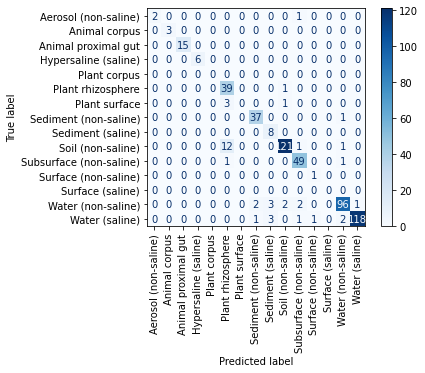

Classification Report


,precision,recall,f1-score,support
Aerosol (non-saline),1.0000,0.6667,0.8000,3
Animal corpus,1.0000,1.0000,1.0000,3
Animal proximal gut,1.0000,1.0000,1.0000,15
Hypersaline (saline),1.0000,1.0000,1.0000,6
Plant rhizosphere,0.7091,0.9750,0.8211,40
Plant surface,0.0000,0.0000,0.0000,4
Sediment (non-saline),0.9250,0.9737,0.9487,38
Sediment (saline),0.5714,1.0000,0.7273,8
Soil (non-saline),0.9680,0.8963,0.9308,135
Subsurface (non-saline),0.9074,0.9608,0.9333,51


Model: XGB
F1 Score 0.9307546221341256
Confusion Matrix


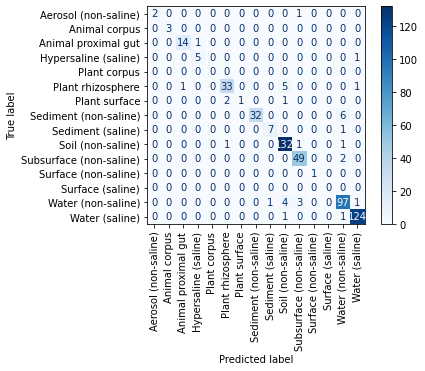

Classification Report


,precision,recall,f1-score,support
Aerosol (non-saline),1.0000,0.6667,0.8000,3
Animal corpus,1.0000,1.0000,1.0000,3
Animal proximal gut,0.9333,0.9333,0.9333,15
Hypersaline (saline),0.8333,0.8333,0.8333,6
Plant rhizosphere,0.9167,0.8250,0.8684,40
Plant surface,1.0000,0.2500,0.4000,4
Sediment (non-saline),1.0000,0.8421,0.9143,38
Sediment (saline),0.8750,0.8750,0.8750,8
Soil (non-saline),0.9231,0.9778,0.9496,135
Subsurface (non-saline),0.9074,0.9608,0.9333,51


Model: Decision Tree
F1 Score 0.8569411953383559
Confusion Matrix


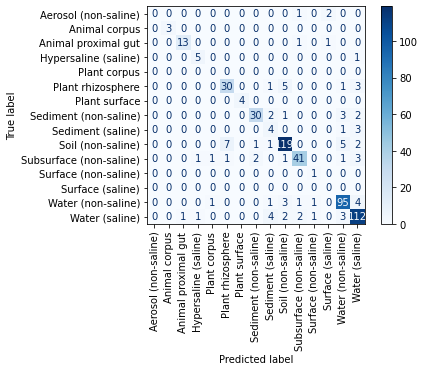

Classification Report


,precision,recall,f1-score,support
Aerosol (non-saline),0.0000,0.0000,0.0000,3
Animal corpus,1.0000,1.0000,1.0000,3
Animal proximal gut,0.9286,0.8667,0.8966,15
Hypersaline (saline),0.7143,0.8333,0.7692,6
Plant corpus,0.0000,0.0000,0.0000,0
Plant rhizosphere,0.7895,0.7500,0.7692,40
Plant surface,1.0000,1.0000,1.0000,4
Sediment (non-saline),0.9091,0.7895,0.8451,38
Sediment (saline),0.3077,0.5000,0.3810,8
Soil (non-saline),0.9084,0.8815,0.8947,135


In [59]:
for model in models.keys():
    print('Model:', model)
    eval_wrapper(y_test['EMPO_3'], models[model]['pred'], main_bool=True)

## Model Explainability (Shap)

In [60]:
explainer_dtc = shap.TreeExplainer(models['Decision Tree']['model'])
shap_values_dtc = explainer_dtc.shap_values(x_train)

In [61]:
shap.summary_plot(shap_values_dtc, x_train, class_names=models['Decision Tree']['model'].classes_, show=False)
plt.legend(loc="lower right")
plt.savefig(f'model_evaluation/shap_decision_tree/shap_images/overall.png', bbox_inches="tight")
plt.close('all')

In [62]:
for i in range(len(shap_values_dtc)):
    cat = models['Decision Tree']['model'].classes_[i]
    vals = np.abs(shap_values_dtc[i]).mean(0)
    feature_importance = pd.DataFrame(list(zip(x_train.columns, vals)), columns=['pfam','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
    feature_importance.to_csv(f'model_evaluation/shap_decision_tree/shap_data/{cat}.csv', index=False)
    shap.summary_plot(shap_values_dtc[i], x_train, class_names=models['Decision Tree']['model'].classes_, show=False)
    plt.savefig(f'model_evaluation/shap_decision_tree/shap_images/{cat}.png', bbox_inches="tight")
    plt.close('all')

In [63]:
explainer_xgb = shap.TreeExplainer(models['XGB']['model'])
shap_values_xgb = explainer_xgb.shap_values(x_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [64]:
shap.summary_plot(shap_values_xgb, x_train, class_names=le.inverse_transform(models['XGB']['model'].classes_), show=False)
plt.legend(loc="lower right")
plt.savefig(f'model_evaluation/shap_xgboost/shap_images/overall.png', bbox_inches="tight")
plt.close('all')

In [65]:
for i in range(len(shap_values_xgb)):
    cat = le.inverse_transform(models['XGB']['model'].classes_)[i]
    vals = np.abs(shap_values_xgb[i]).mean(0)
    feature_importance = pd.DataFrame(list(zip(x_train.columns, vals)), columns=['pfam','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
    feature_importance.to_csv(f'model_evaluation/shap_xgboost/shap_data/{cat}.csv', index=False)
    shap.summary_plot(shap_values_xgb[i], x_train, class_names=le.inverse_transform(models['XGB']['model'].classes_), show=False)
    plt.savefig(f'model_evaluation/shap_xgboost/shap_images/{cat}.png', bbox_inches="tight")
    plt.close('all')

In [66]:
# Would take days to run, even on M1 Pro chip
#explainer_nn = shap.KernelExplainer(models['NN']['model'], shap.sample(x_train, 100))
#shap_values_nn = explainer_nn.shap_values(x_test)